**RMSD & Q Plots**

This notebook generates RMSD (Root Mean Squared Deviation) vs Q (Percent Native Contacts) plots to compare two trajectories. Both plots are generated based on carbon alphas (CAs) only.

RMSD represents how much the distance between each pair of CAs has changed from the "native" conformation. 

"Native contacts" are all the CA pairs closer than some arbitrary distance in the native conformation, and the Q value for a frame is the percentage of these that are still within that cutoff distance.

Reference: https://userguide.mdanalysis.org/1.1.1/examples/analysis/distances_and_contacts/contacts_native_fraction.html

In [10]:
import os
import glob
import mdtraj
from matplotlib import pyplot as plt

import itertools
import numpy as np

In [11]:
def calculate_q_rmsd(native, sim_traj, target_frame_count=None):
    # https://userguide.mdanalysis.org/1.1.1/examples/analysis/distances_and_contacts/contacts_native_fraction.html

    if isinstance(native, str):
        native_traj = mdtraj.load_frame(native, 0)
    else:
        native_traj = native[0]

    ca_atoms = native_traj.topology.select("name CA")
    all_ca_pairs = np.array([i for i in itertools.product(ca_atoms, ca_atoms) if i[0] != i[1]])
    native_dist = mdtraj.compute_distances(native_traj[0], all_ca_pairs)[0]

    if isinstance(sim_traj, str):
        sim_traj = mdtraj.load(sim_traj)
        if target_frame_count:
            sim_traj = sim_traj[::max(1,len(sim_traj)//target_frame_count)]

    ca_atoms = sim_traj.topology.select("name CA")
    all_ca_pairs = np.array([i for i in itertools.product(ca_atoms, ca_atoms) if i[0] != i[1]])

    # native_dist = mdtraj.compute_distances(sim_traj[0], all_ca_pairs)[0]
    # print(len(all_ca_pairs), len(native_dist))
    native_pairs = all_ca_pairs[native_dist < 0.8]
    print("pairs:", len(all_ca_pairs), "native:", len(native_pairs))

    percent_native = np.sum(mdtraj.compute_distances(sim_traj, native_pairs)<0.8,axis=1)/len(native_pairs)
    rmsd_values = mdtraj.rmsd(sim_traj, native_traj, atom_indices=ca_atoms)
    return(percent_native, rmsd_values)

In [12]:
def make_plot_grid(length, row_len=3):
    fig, axes = plt.subplots((length+row_len-1)//row_len, min(row_len, length))
    # Ensure axes is always a 2d array
    if isinstance(axes, plt.Axes):
        axes = np.array([[axes]])
    elif len(axes.shape) == 1:
        axes = axes[np.newaxis, :]
    for i in range(length,len(axes.flat)):
        axes.flat[i].remove()
    fig.set_figheight(6*len(axes))
    fig.set_figwidth(6*len(axes[0]))
    return fig, axes

In [13]:
coordinate_files = [
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/cg_Majewski_prior_2024.07.06/6MRR/raw/coordinates.npy",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_Majewski_prior_2024.07.06_SiLU__wd0_lr2.5en4__6MRR_*.h5",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_2024.06.26_400fs_CA_lj_angle_SiLU__wd0_lr2.5en4__6MRR_*.h5",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_Majewski_prior_2024.08.03_constrain_SiLU_cutoff2__wd0_lr2.5en4__smax128__6MRR_*.h5",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_Majewski_prior_2024.08.03_constrain_tag_SiLU_cutoff2__wd0_explr1en3_0.85__smax128__6MRR_*.h5",
]

# Select another protein from the same set of models
# coordinate_files = [i.replace("6MRR", "5YM7") for i in coordinate_files]
# coordinate_files = [i.replace("6MRR", "3ID4") for i in coordinate_files]
# coordinate_files = [i.replace("6MRR", "2VQ4") for i in coordinate_files]

coordinate_list = []
label_list = []
subtraj_lengths_list = []

for cf in coordinate_files:
    label_list.append(os.path.basename(cf))
    batch_traj = []
    # batch_tags = []
    subtraj_lengths = []
    for subtraj in glob.glob(cf):
        if subtraj.endswith("npy"):
            coords = np.load(subtraj)
            # Select with a stride that brings the total down to ~10,000
            if len(coords > 10000):
                coords = coords[::(len(coords)//10000)]
            # Convert to NM to match mdtraj coordinates
            coords = coords/10
            psf_path = glob.glob(os.path.join(os.path.dirname(cf),"../processed/*_processed.psf"))[0]
            traj = mdtraj.Trajectory(coords, topology=mdtraj.formats.psf.load_psf(psf_path))
        else:
            traj = mdtraj.load(subtraj)
        batch_traj.append(traj)
        # batch_tags.append(np.repeat(len(batch_tags)+1, len(traj)))
        subtraj_lengths.append(len(traj))
    if len(batch_traj) == 0:
        print("Failed to load:", cf)
    coordinate_list.append(mdtraj.join(batch_traj))
    # traj_tags_list.append(np.concatenate(batch_tags))
    subtraj_lengths_list.append(subtraj_lengths)

assert len(coordinate_list) == len(label_list)
print(coordinate_list)

[<mdtraj.Trajectory with 10000 frames, 68 atoms, 68 residues, without unitcells at 0x7efc983b9b10>, <mdtraj.Trajectory with 5000 frames, 68 atoms, 68 residues, without unitcells at 0x7efc8c356cb0>, <mdtraj.Trajectory with 5000 frames, 68 atoms, 68 residues, without unitcells at 0x7efc8c67b4c0>, <mdtraj.Trajectory with 5000 frames, 68 atoms, 68 residues, without unitcells at 0x7efc94090970>, <mdtraj.Trajectory with 5000 frames, 68 atoms, 68 residues, without unitcells at 0x7efc8c6c07c0>]


In [14]:
traj_values = [calculate_q_rmsd(coordinate_list[0][0], i, target_frame_count=10000) for i in coordinate_list]

pairs: 4556 native: 548
pairs: 4556 native: 548
pairs: 4556 native: 548
pairs: 4556 native: 548
pairs: 4556 native: 548


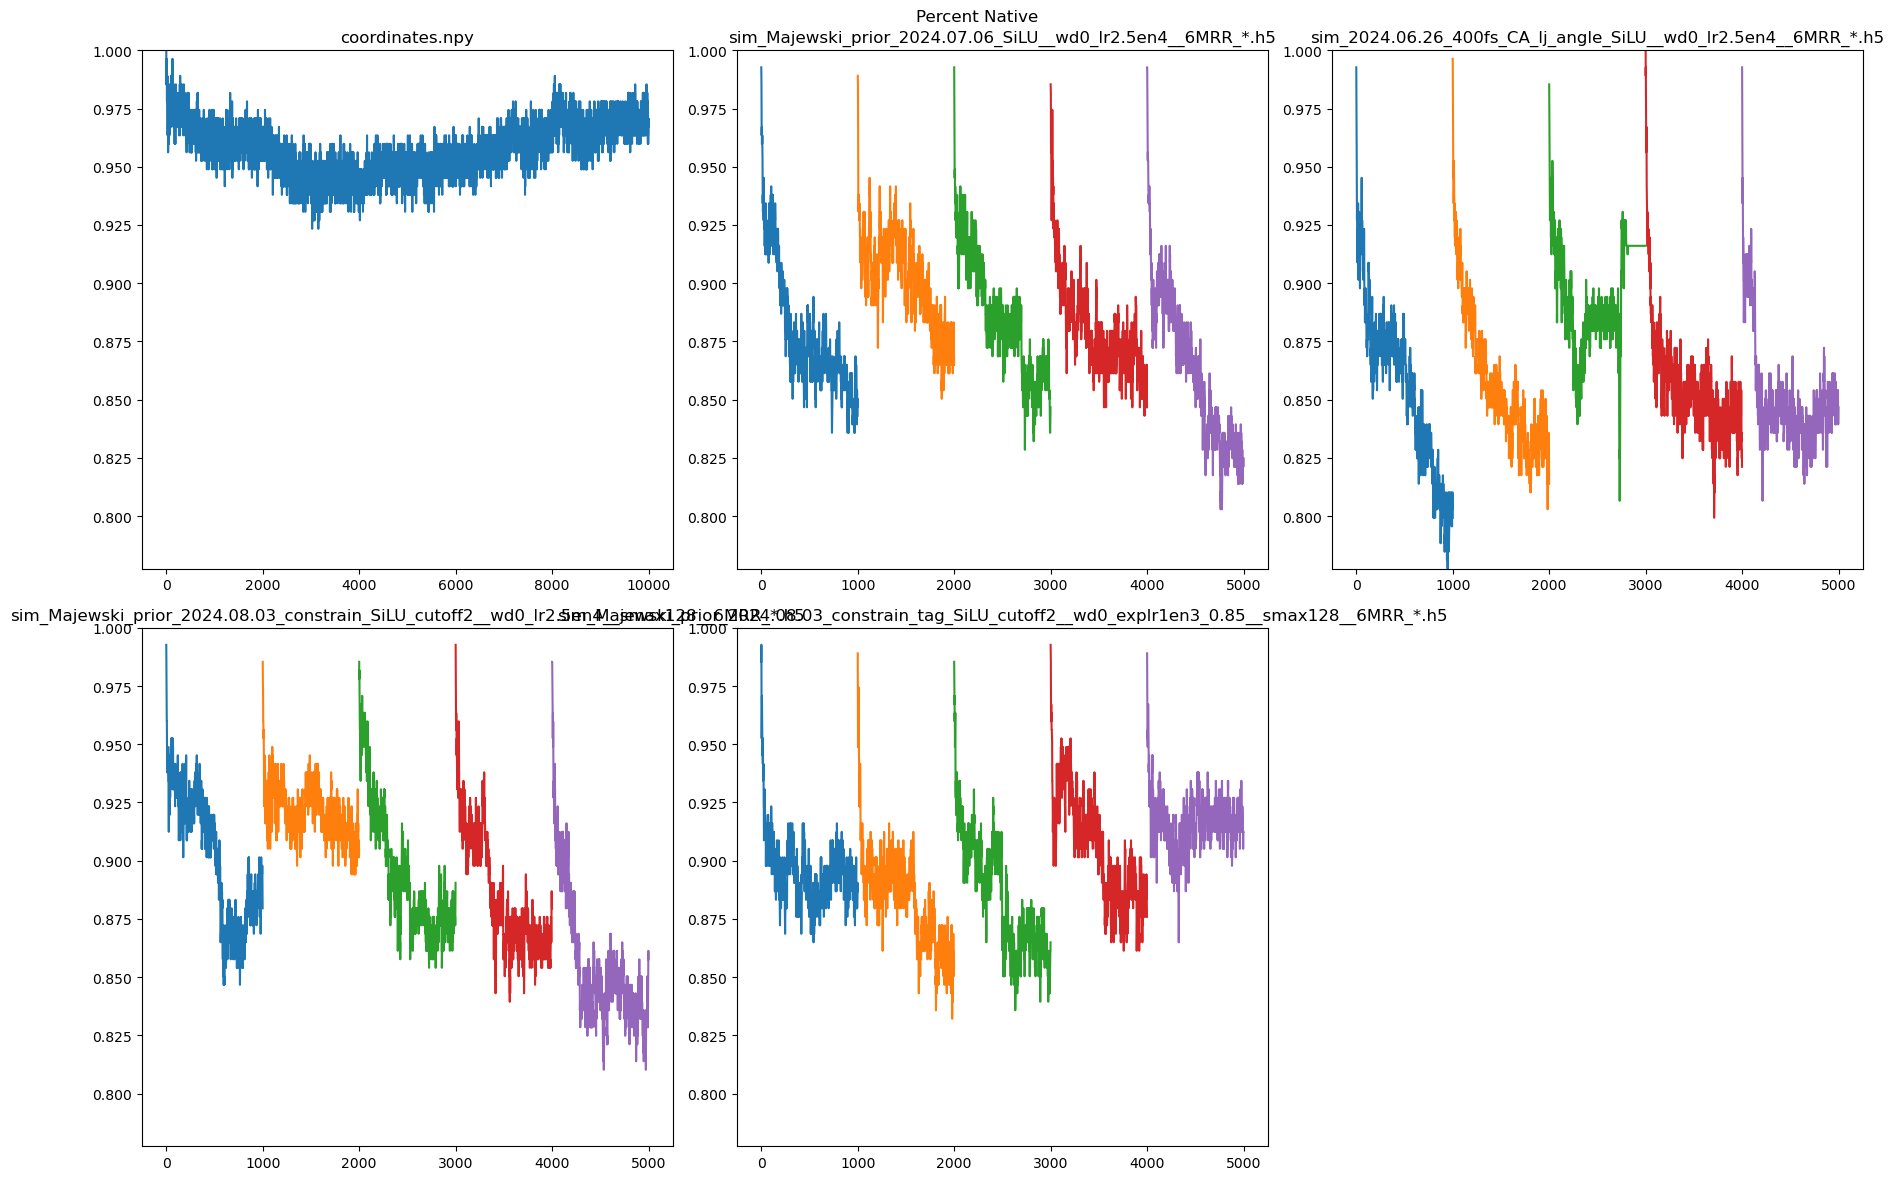

In [15]:
fig, axes = make_plot_grid(len(traj_values))
fig.suptitle('Percent Native')

y_min = np.min([np.min(tv[0]) for tv in traj_values])
for ax, tv, label, subtraj_lengths in zip(axes.flat, traj_values, label_list, subtraj_lengths_list):
    ax.set_title(label)
    x = range(len(tv[0]))
    start = 0
    for i in subtraj_lengths:
        ax.plot(x[start:start+i], tv[0][start:start+i])
        start += i
    ax.set_ylim(y_min, 1.0)
fig.set_tight_layout(True)
pass

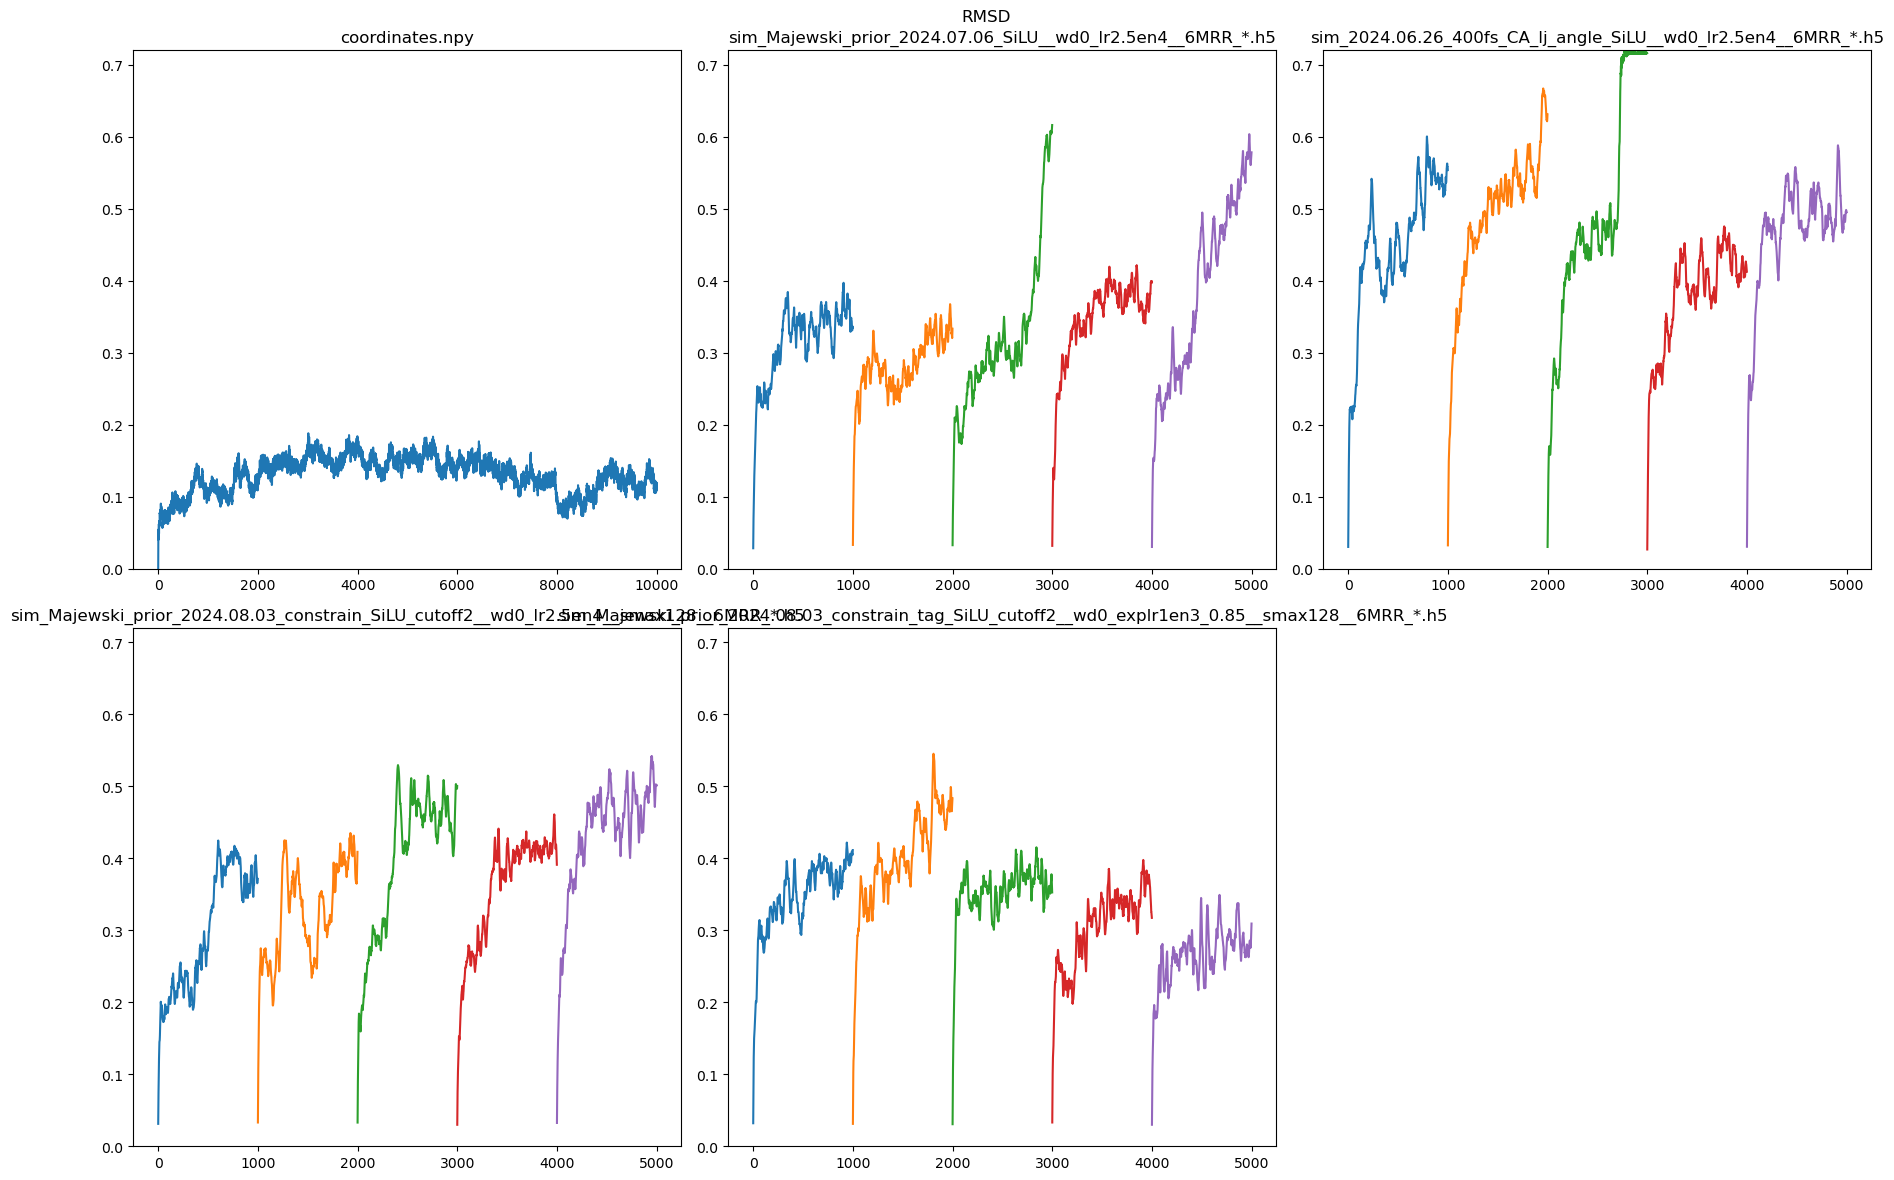

In [16]:
fig, axes = make_plot_grid(len(traj_values))
fig.suptitle('RMSD')
y_max = np.max([np.max(tv[1]) for tv in traj_values])
for ax, tv, label, subtraj_lengths in zip(axes.flat, traj_values, label_list, subtraj_lengths_list):
    ax.set_title(label)
    # ax.plot(range(len(tv[1])), tv[1])
    x = range(len(tv[1]))
    start = 0
    for i in subtraj_lengths:
        ax.plot(x[start:start+i], tv[1][start:start+i])
        start += i
    ax.set_ylim(0, y_max)
fig.set_tight_layout(True)
pass

In [17]:
def calc_rmsd_plot_bounds(traj, other_bounds=None):
    axis_xmin = np.min(traj[0])*0.9
    axis_xmax = np.max(traj[0])*1.1
    axis_ymin = np.min(traj[1])*0.9
    axis_ymax = np.max(traj[1])*1.1
    if other_bounds:
        axis_xmin = min(axis_xmin, other_bounds[0][0])
        axis_xmax = max(axis_xmax, other_bounds[0][1])
        axis_ymin = min(axis_ymin, other_bounds[1][0])
        axis_ymax = max(axis_ymax, other_bounds[1][1])

    return ((axis_xmin, axis_xmax), (axis_ymin, axis_ymax))

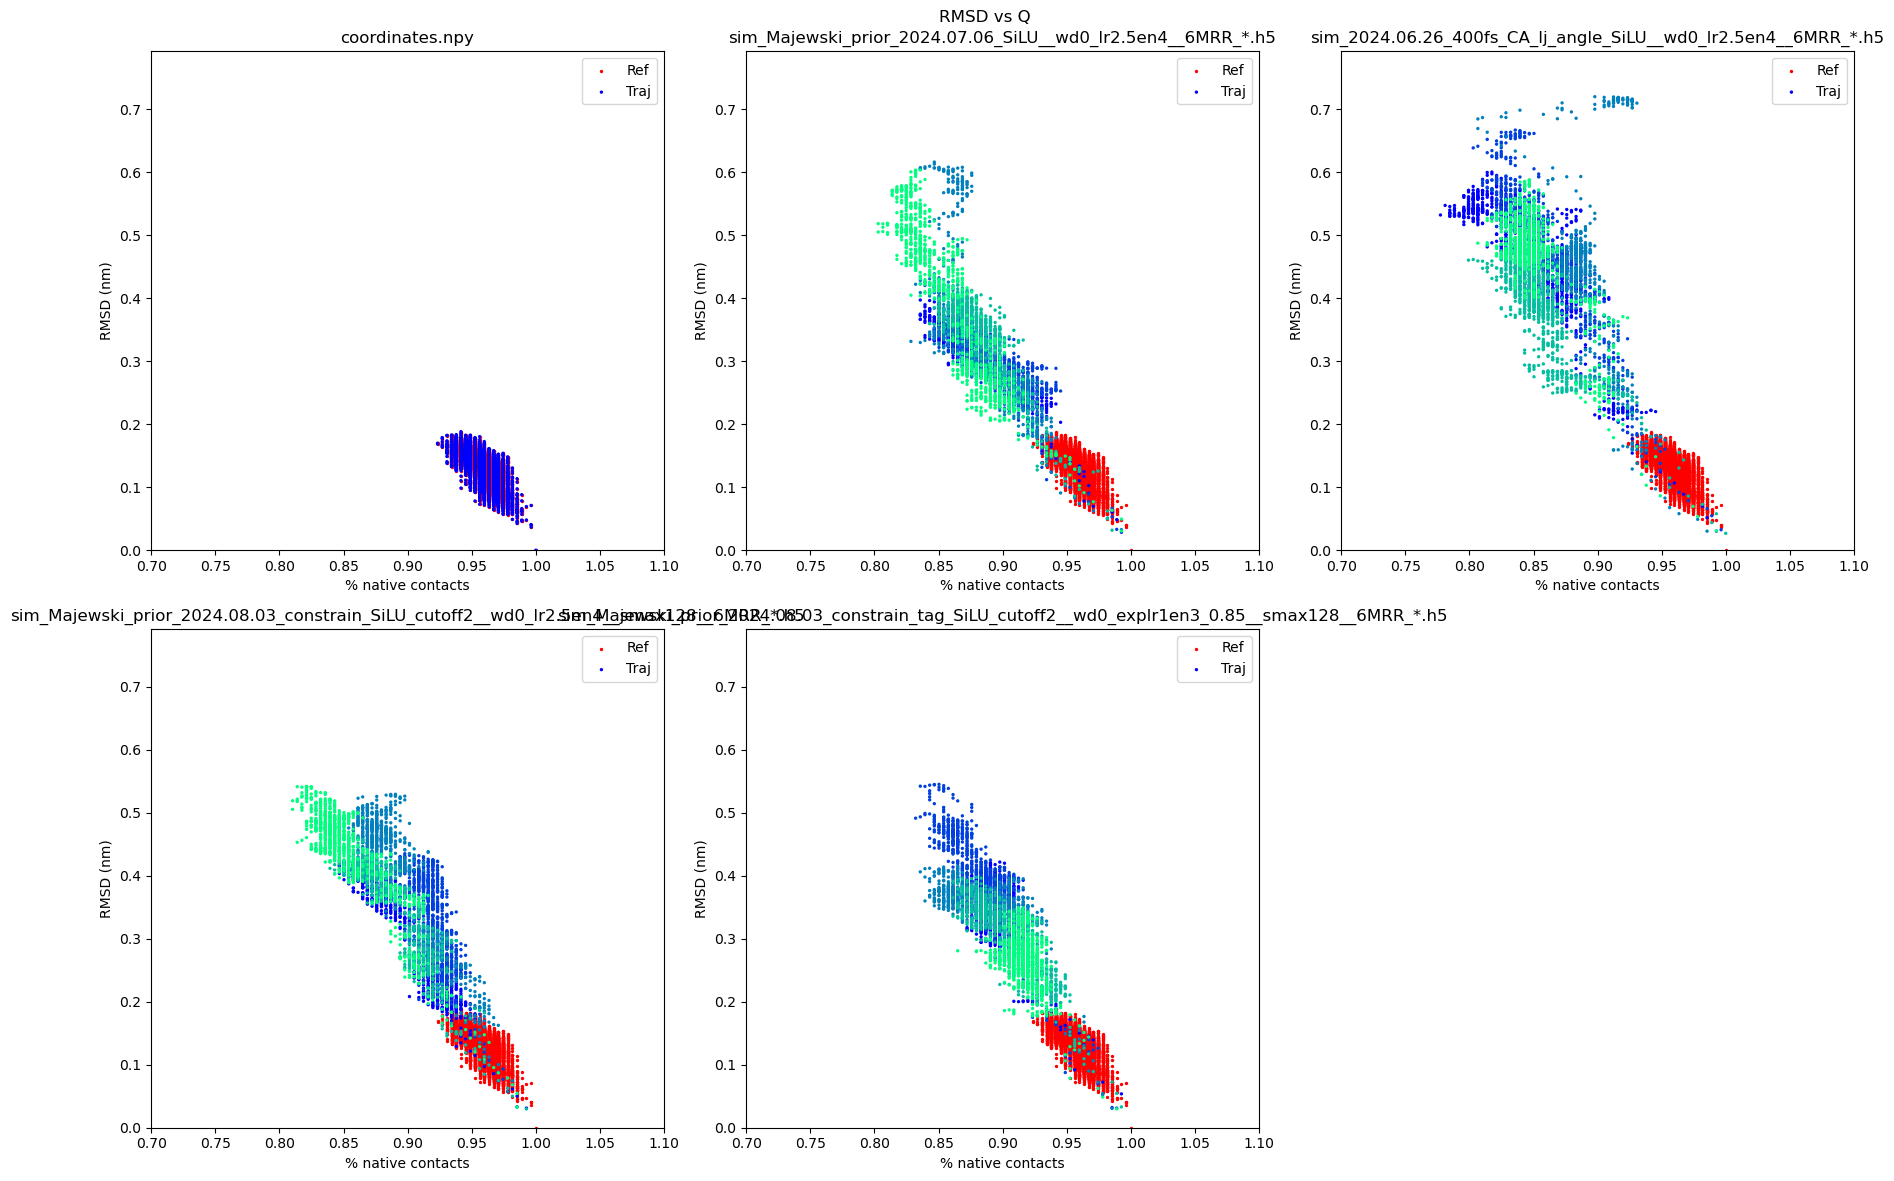

In [18]:
fig, axes = make_plot_grid(len(traj_values))
fig.suptitle('RMSD vs Q')

traj_bounds = calc_rmsd_plot_bounds(traj_values[0])
for tv in traj_values[1:]:
    traj_bounds = calc_rmsd_plot_bounds(tv, traj_bounds)

# base_traj_bounds = calc_rmsd_plot_bounds(traj_values[0])

for ax, tv, label, subtraj_lengths in zip(axes.flat, traj_values, label_list, subtraj_lengths_list):
    # traj_bounds = calc_rmsd_plot_bounds(tv, base_traj_bounds)
    ax.set_title(label)

    ax.set_xlabel("% native contacts")
    ax.set_ylabel("RMSD (nm)")

    ax.set_xlim(*traj_bounds[0])
    ax.set_ylim(*traj_bounds[1])

    plot_colors = np.concatenate([np.repeat(i, j) for i,j in enumerate(subtraj_lengths)])
    ax.scatter(traj_values[0][0], traj_values[0][1], color="red", s=2, label="Ref")
    ax.scatter(tv[0], tv[1], c=plot_colors, cmap="winter", s=2, label="Traj")
    ax.legend()

fig.set_tight_layout(True)
pass